# 0 Imports

In [149]:
import inflection
import math
import datetime
import random
import pandas              as pd
import numpy               as np
import seaborn             as sns
import matplotlib.pyplot   as plt
import matplotlib.gridspec as gridspec
import scipy.stats         as ss
import xgboost             as xgb
import warnings
import pickle


from flask                 import Flask, request, Response
from matplotlib            import rcParams
from IPython.display       import Image
from tabulate              import tabulate
from boruta                import BorutaPy
from sklearn.preprocessing import RobustScaler,MinMaxScaler,LabelEncoder
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.ensemble      import RandomForestRegressor
from catboost              import CatBoostRegressor

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.style.use("classic")

##  0.1 Helper functions

In [150]:
def cramer_v (x,y):
    cm = pd.crosstab(x,y).values
    n=cm.sum()
    r,k=cm.shape

    chi2=ss.chi2_contingency(cm)[0]
    chi2corr=max(0,chi2 - (k-1) * (r-1) / (n-1))
    
    kcorr=k - (k-1)**2/(n-1)
    rcorr=r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2/n) / (min(k-1,r-1)))


def mean_absolute_percentage_error(y,yhat):
    return np.mean(np.abs((y-yhat)/y))


def mean_percentage_error(y,yhat):
    return np.mean((y-yhat)/y)


def ml_error (model_name,y,yhat):
    mae=mean_absolute_error(y,yhat)
    mape=mean_absolute_percentage_error(y,yhat)
    rmse=np.sqrt(mean_squared_error(y,yhat))
    
    return pd.DataFrame({'Model Name':model_name,
                       'MAE':mae,
                        'MAPE':mape,
                        'RMSE':rmse},index=[0]
                       )


def cross_validation(x_training,kfold,model_name,model,verbose=False):          
    mae_list=[]
    mape_list=[]
    rmse_list=[]

    for k in reversed (range(1,kfold+1)):                    
        if verbose:                                           
            print('\n KFold Number: {}'.format (k))

        # start and end date for validation
        validation_start_date=x_training['date'].max() - datetime.timedelta (days=k*6*7)
        validation_end_date=x_training['date'].max() - datetime.timedelta (days=(k-1)*6*7)

        
        # filtering dataset
        training  =x_training[x_training['date']<validation_start_date]

        validation=x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]
        
        # training and validation dataset
        # training
        xtraining=training.drop(['date','sales'],axis=1)
        ytraining=training['sales']

        
        # validation (teste)
        xvalidation=validation.drop(['date','sales'],axis=1)
        yvalidation=validation['sales']


        # model
        m=model.fit(xtraining,ytraining)

        
        # prediction
        yhat=m.predict(xvalidation)    

        
        # performance
        m_result=ml_error (model_name,np.expm1 (yvalidation), np.expm1 (yhat))  
        
        # store performance of each kfold iteration
        mae_list.append (m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

        
    return pd.DataFrame({'Model name':model_name, 
                        'MAE CV': np.round(np.mean(mae_list),2).astype(str) + ' +/-' + np.round(np.std(mae_list),2).astype(str),       #cv=cross validation
                        'MAPE CV': np.round(np.mean(mape_list),2).astype(str) + ' +/-' + np.round(np.std(mape_list),2).astype(str),
                        'RMSE CV': np.round(np.mean(rmse_list),2).astype(str) + ' +/-' + np.round(np.std(rmse_list),2).astype(str)},index=[0]) #index=0 devido à criação do df

## 0.2 Loading data

In [151]:
df_sales_raw=pd.read_csv('../data/train.csv',low_memory=False)
df_store_raw=pd.read_csv('../data/store.csv',low_memory=False)

# merge
df_raw=pd.merge(df_sales_raw,df_store_raw,how='left',on='Store')

# **1 Data Description** 

In [4]:
df1=df_raw.copy()

In [5]:
df1.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## **1.1 Rename columns**

In [6]:
cols_old=['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase=lambda x: inflection.underscore(x)
cols_new=list(map(snakecase,cols_old))

# rename
df1.columns=cols_new

## 1.2 Data Dimensions

In [7]:
print(f'Number of rows:{df1.shape[0]}')
print(f'Number of cols:{df1.shape[1]}')

Number of rows:1017209
Number of cols:18


## 1.3 Data types

In [8]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

### **1.3.1 Change types**

In [9]:
df1['date'] = pd.to_datetime( df1['date'] )

## 1.4 Check NA

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [11]:
# competition_distance            
df1['competition_distance']=df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)


# competition_open_since_month    
df1['competition_open_since_month']=df1.apply( lambda x: x['date'].month if math.isnan (x['competition_open_since_month'] )
                                                                               else x ['competition_open_since_month'],axis=1 )

# competition_open_since_year   
df1['competition_open_since_year']=df1.apply( lambda x: x['date'].year if math.isnan (x['competition_open_since_year'] )
                                                                               else x ['competition_open_since_year'],axis=1 )

# promo2_since_week               
df1['promo2_since_week']=df1.apply( lambda x: x['date'].week if math.isnan (x['promo2_since_week'] )
                                                                               else x ['promo2_since_week'],axis=1 )

# promo2_since_year             
df1['promo2_since_year']=df1.apply( lambda x: x['date'].year if math.isnan (x['promo2_since_year'] )
                                                                               else x ['promo2_since_year'],axis=1 )

#promo_interval
month_map={1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sept',10:'Oct',11:'Nov',12:'Dec'}

df1['promo_interval'].fillna(0,inplace=True)

df1['month_map']  = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )


## 1.6 Change Types

In [12]:
# df1.dtypes

# date
df1['date']=pd.to_datetime(df1['date'])

# competiton
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )
    
# promo2
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

## 1.7 Descriptive statistics

In [13]:
num_attributes = df1.select_dtypes( include=['int64', 'float64','int32'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1 Numerical attributes

In [14]:
# Central Tendency - mean, median 
ct1=pd.DataFrame(num_attributes.apply(np.mean)).T
ct2=pd.DataFrame(num_attributes.apply(np.median)).T


# dispersion - std, min, max, range, skew, kurtosis
d1=pd.DataFrame(num_attributes.apply(np.std)).T
d2=pd.DataFrame(num_attributes.apply(min)).T
d3=pd.DataFrame(num_attributes.apply(max)).T
d4=pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min () )).T
d5=pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
d6=pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T

# concatenate
m=pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2 Categorical attributes

In [15]:
cat_attributes.apply(lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

In [16]:
df1['state_holiday'].unique()

array(['0', 'a', 'b', 'c'], dtype=object)

In [17]:
df1['store_type'].unique()

array(['c', 'a', 'd', 'b'], dtype=object)

In [18]:
df1['assortment'].unique()

array(['a', 'c', 'b'], dtype=object)

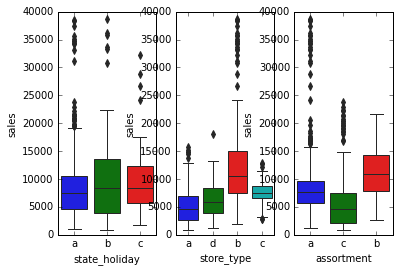

In [19]:
rcParams['figure.figsize'] = 18,7

aux1=df1[(df1['state_holiday'] !='0') & (df1['sales']>0)]


plt.subplot(1,3,1);
sns.boxplot(x='state_holiday',y='sales',data=aux1);

plt.subplot(1,3,2);
sns.boxplot(x='store_type',y='sales',data=aux1);

plt.subplot(1,3,3);
sns.boxplot(x='assortment',y='sales',data=aux1);

# 2 Feature Engineering

In [20]:
df2=df1.copy()

In [21]:
df2.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9,2008,0,31,2015,0,Jul,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9,2009,0,31,2015,0,Jul,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4,2015,0,31,2015,0,Jul,0


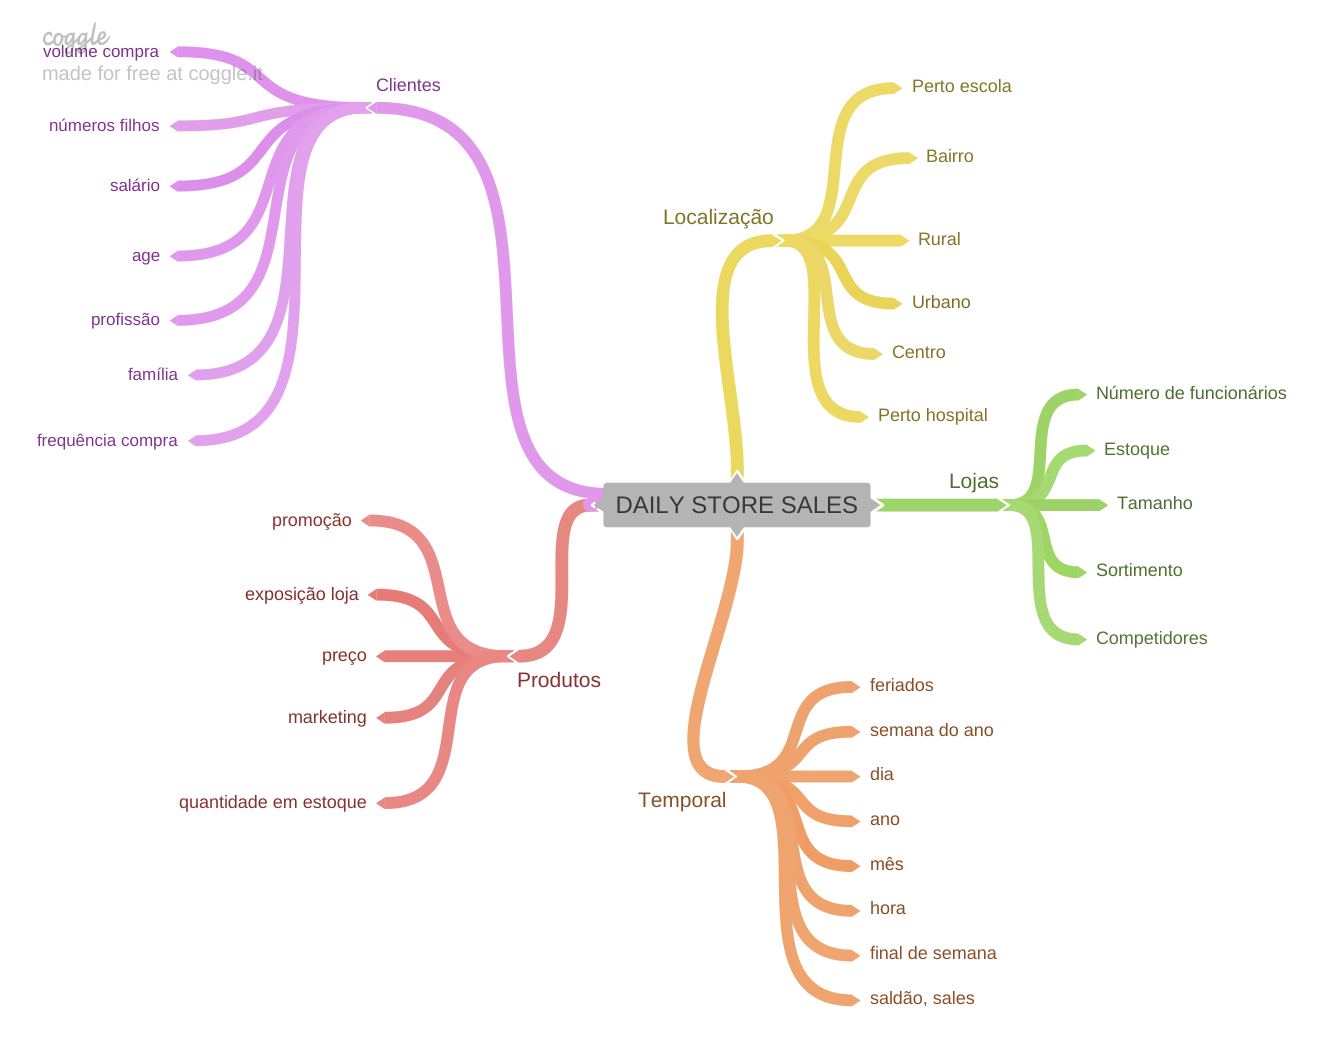

In [22]:
Image('../img/DAILY_STORE_SALES.png')

## 2.1 Hypothesis creation


### 2.1.1 Stores

**1** more employees = more sales

**2** bigger stock = more sales

**3** bigger store = more sales

**4** smaller store = more sales

**5** more assortment = more sales

### 2.1.2 Product

**1** more marketing = more sales

**2** more exposure = more sales

**3** smaller prices = more sales

**4** agressive promotions (bigger discounts) = more sales

**5** promotions active for longer = more sales

**6** more promotion days = more sales

**7** more consecutive promotions = more sales

### 2.1.3 Time

**1** stores open in christimas sell more

**2** stores sell more over the years

**3** second semester = more sales

**4** after the tenth day = more sales

**5** weekends = less sales

**6** school holidays = less sales

## 2.2 Final list of hypotheses

**1.** Stores with greater assortments should sell more.

**2.** Stores with closer competitors should sell less.

**3.** Stores with competitors for a longer time should sell more.

**4.** Stores with promotions active for longer should sell more.

**5.** Stores with more days on promotion should sell more.

**6.** Stores with more consecutive promotions should sell more.

**7.** Stores open over the Christmas holiday should sell more.

**8.** Stores should sell more over the years.

**9.** Stores should sell more in the second half of the year.

**10.** Stores should sell more after the 10th of every month.

**11.** Stores should sell less on weekends.

**12.** Stores should sell less during school holidays.

## 2.3 Feature Engineering

In [23]:
# year
df2['year']=df2['date'].dt.year

# month
df2['month']=df2['date'].dt.month

# day
df2['day']=df2['date'].dt.day

# week of year
df2['week_of_year']=df2['date'].dt.weekofyear

# year week
df2['year_week']=df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since']=df2.apply (lambda x: datetime.datetime(year=x['competition_open_since_year'],month=x['competition_open_since_month'],day=1),axis=1)
df2['competition_time_month']=((df2['date']-df2['competition_since'])/30).apply(lambda x: x.days).astype(int)


# promo since
df2['promo_since']=df2['promo2_since_year'].astype(str)+'-'+df2['promo2_since_week'].astype(str)
df2['promo_since']=df2['promo_since'].apply(lambda x: datetime.datetime.strptime (x+'-1', '%Y-%W-%w')) - datetime.timedelta(days=7)
df2['promo_time_week']=((df2['date']-df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment']=df2['assortment'].apply(lambda x: 'basic'if x =='a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

In [24]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3 Variable filtering

In [25]:
df3=df2.copy()

## 3.1 Row filtering

In [26]:
df3=(df3[df3['open']==1]) 
df3=df3[df3['sales']>0]

## 3.2 Column filtering

In [27]:
cols_drop=['customers','open','promo_interval','month_map']
df3=df3.drop(cols_drop,axis=1)

#  4 Exploratory data analysis

In [28]:
df4=df3.copy()

## 4.1 Univariate analysis

### 4.1.1 Response variable

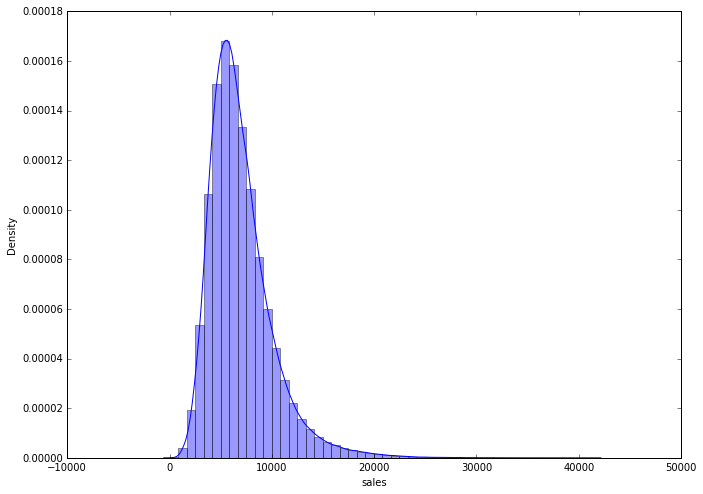

In [29]:
rcParams['figure.figsize'] = 11,8
sns.distplot(df4['sales']);

### 4.1.2 Numerical variables

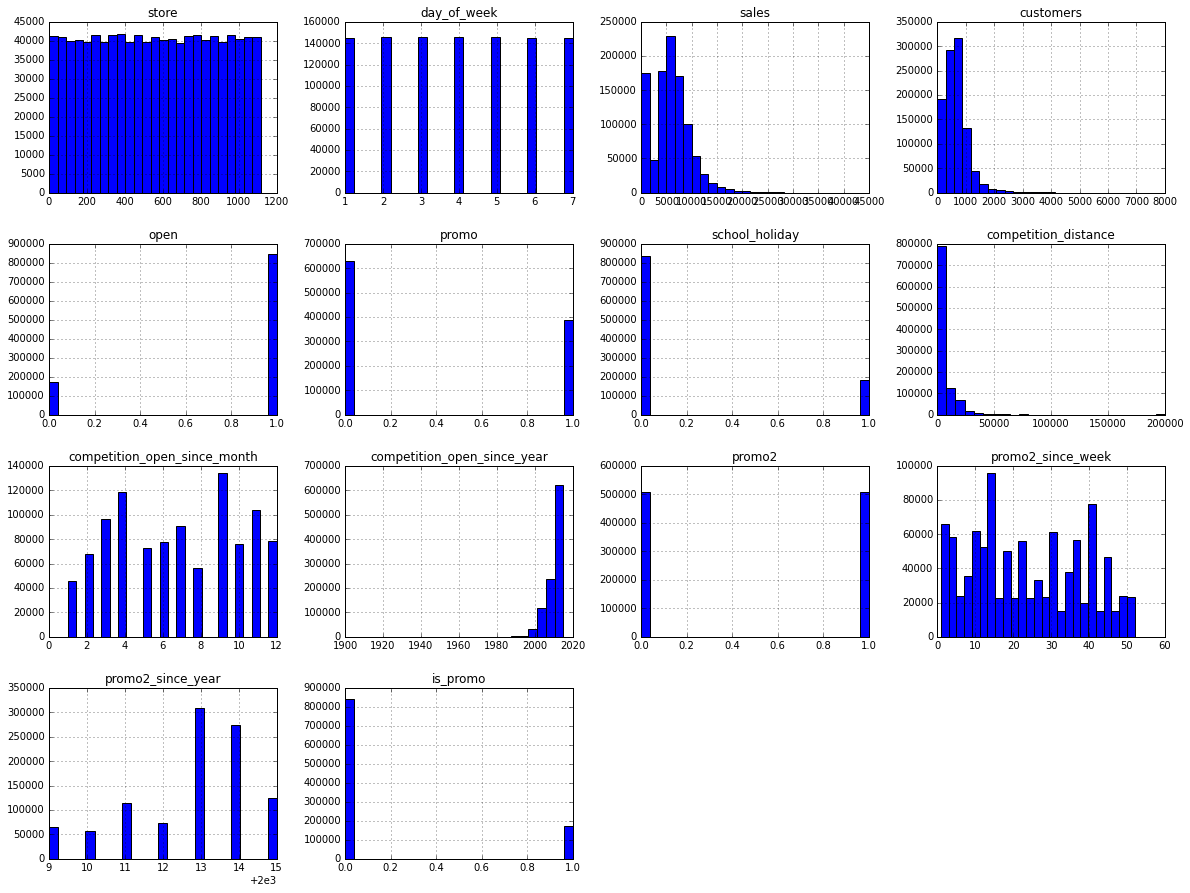

In [30]:
rcParams['figure.figsize'] = 20,15
num_attributes.hist(bins=25);

### 4.1.3 Categorical variables

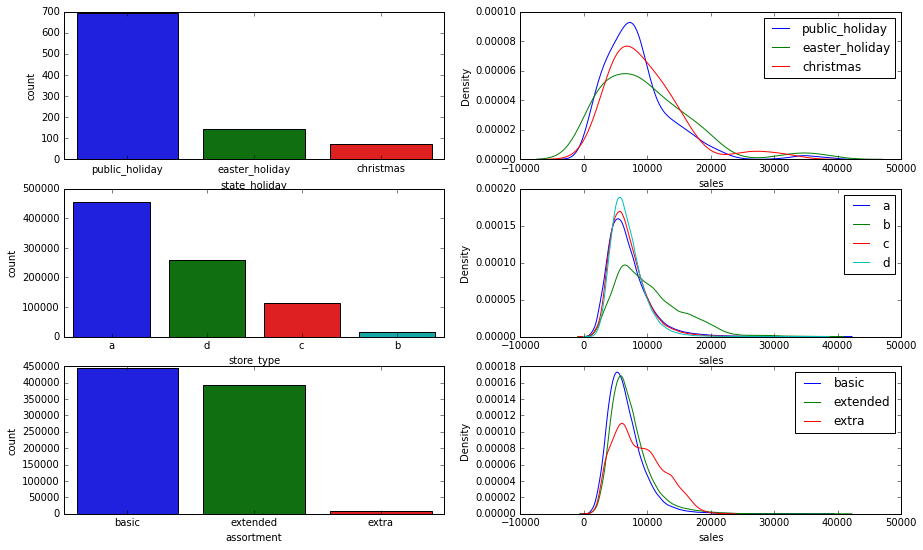

In [31]:
rcParams['figure.figsize'] = 15,9

# state_holiday
plt.subplot(3,2,1);
a=df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x=a['state_holiday']);

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday']=='public_holiday']['sales'],label='public_holiday',shade=False);
sns.kdeplot(df4[df4['state_holiday']=='easter_holiday']['sales'],label='easter_holiday',shade=False);
sns.kdeplot(df4[df4['state_holiday']=='christmas']['sales'],label='christmas',shade=False);
plt.legend();

# store_type
plt.subplot(3,2,3);
sns.countplot(x=df4['store_type'],order = df4['store_type'].value_counts().index);

plt.subplot(3,2,4);
sns.kdeplot(df4[df4['store_type']=='a']['sales'],label='a',shade=False);
sns.kdeplot(df4[df4['store_type']=='b']['sales'],label='b',shade=False);
sns.kdeplot(df4[df4['store_type']=='c']['sales'],label='c',shade=False);
sns.kdeplot(df4[df4['store_type']=='d']['sales'],label='d',shade=False);
plt.legend();

# assortment
plt.subplot(3,2,5);
sns.countplot(x=df4['assortment']);

plt.subplot(3,2,6);
sns.kdeplot(df4[df4['assortment']=='basic']['sales'],label='basic',shade=False);
sns.kdeplot(df4[df4['assortment']=='extended']['sales'],label='extended',shade=False);
sns.kdeplot(df4[df4['assortment']=='extra']['sales'],label='extra',shade=False);
plt.legend();

## 4.2 Análise bivariada

### **H1.** Stores with greater assortments should sell more
**true** Stores with greater assortments sell more

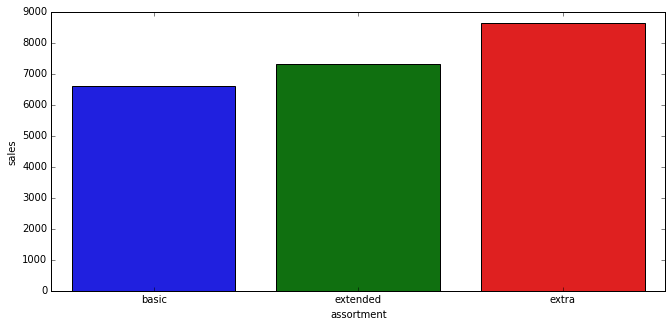

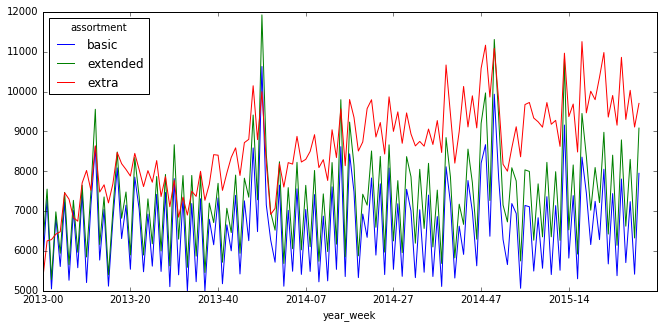

In [32]:
rcParams['figure.figsize'] = 11,5

aux1=df4[['assortment','sales']].groupby('assortment').mean().reset_index()
sns.barplot(x='assortment',y='sales',data=aux1);

aux2=df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).mean().reset_index()
aux3=aux2.pivot(index='year_week',columns='assortment',values='sales')
aux2.pivot(index='year_week',columns='assortment',values='sales').plot();

### **H2.** Stores with closer competitors should sell less
**false** the distance between stores doesn't affect the sales


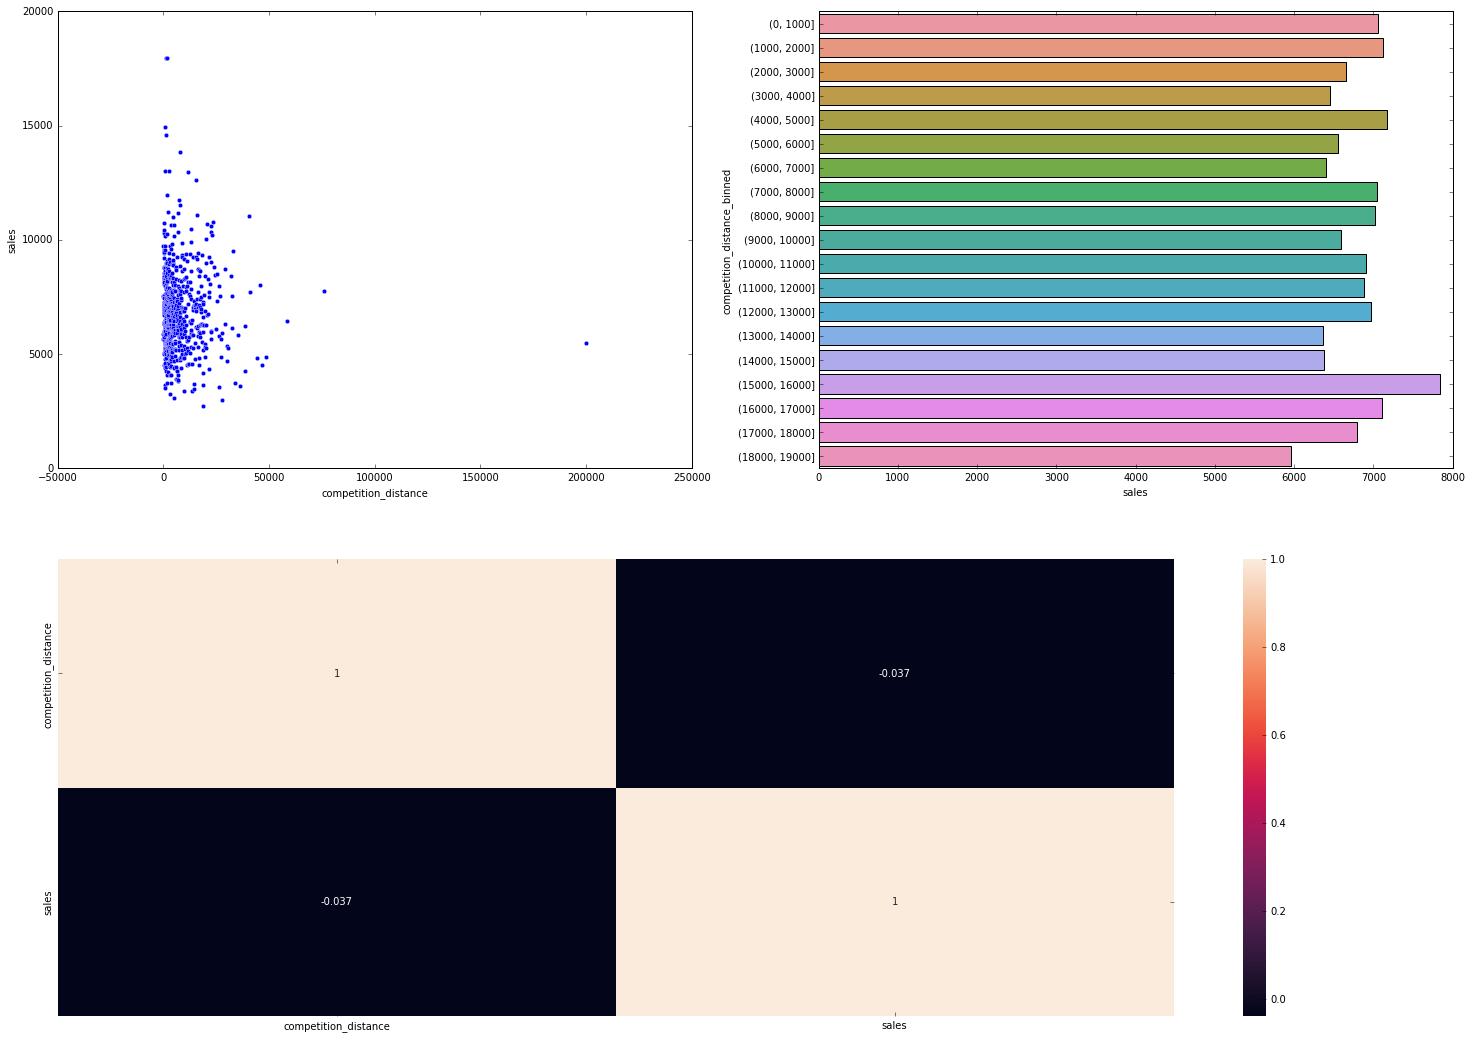

In [33]:
rcParams['figure.figsize'] = 25,18

aux1=df4[['competition_distance','sales']].groupby('competition_distance').mean().reset_index()

grid=gridspec.GridSpec(2,2)

plt.subplot(grid[0,0])
sns.scatterplot(x='competition_distance',y='sales',data=aux1);

plt.subplot(grid[0,1])
bins=list(np.arange(0,20000,1000))
aux1['competition_distance_binned']=pd.cut(aux1['competition_distance'],bins=bins)
aux2=aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').mean().reset_index()
sns.barplot(x='sales',y='competition_distance_binned',data=aux2);

plt.subplot(grid[1,:])
sns.heatmap(aux1.corr(method='pearson'),annot=True);

### **H3.** Stores with competitors for a longer time should sell more
**false** stores with competitors for a longer time sell less

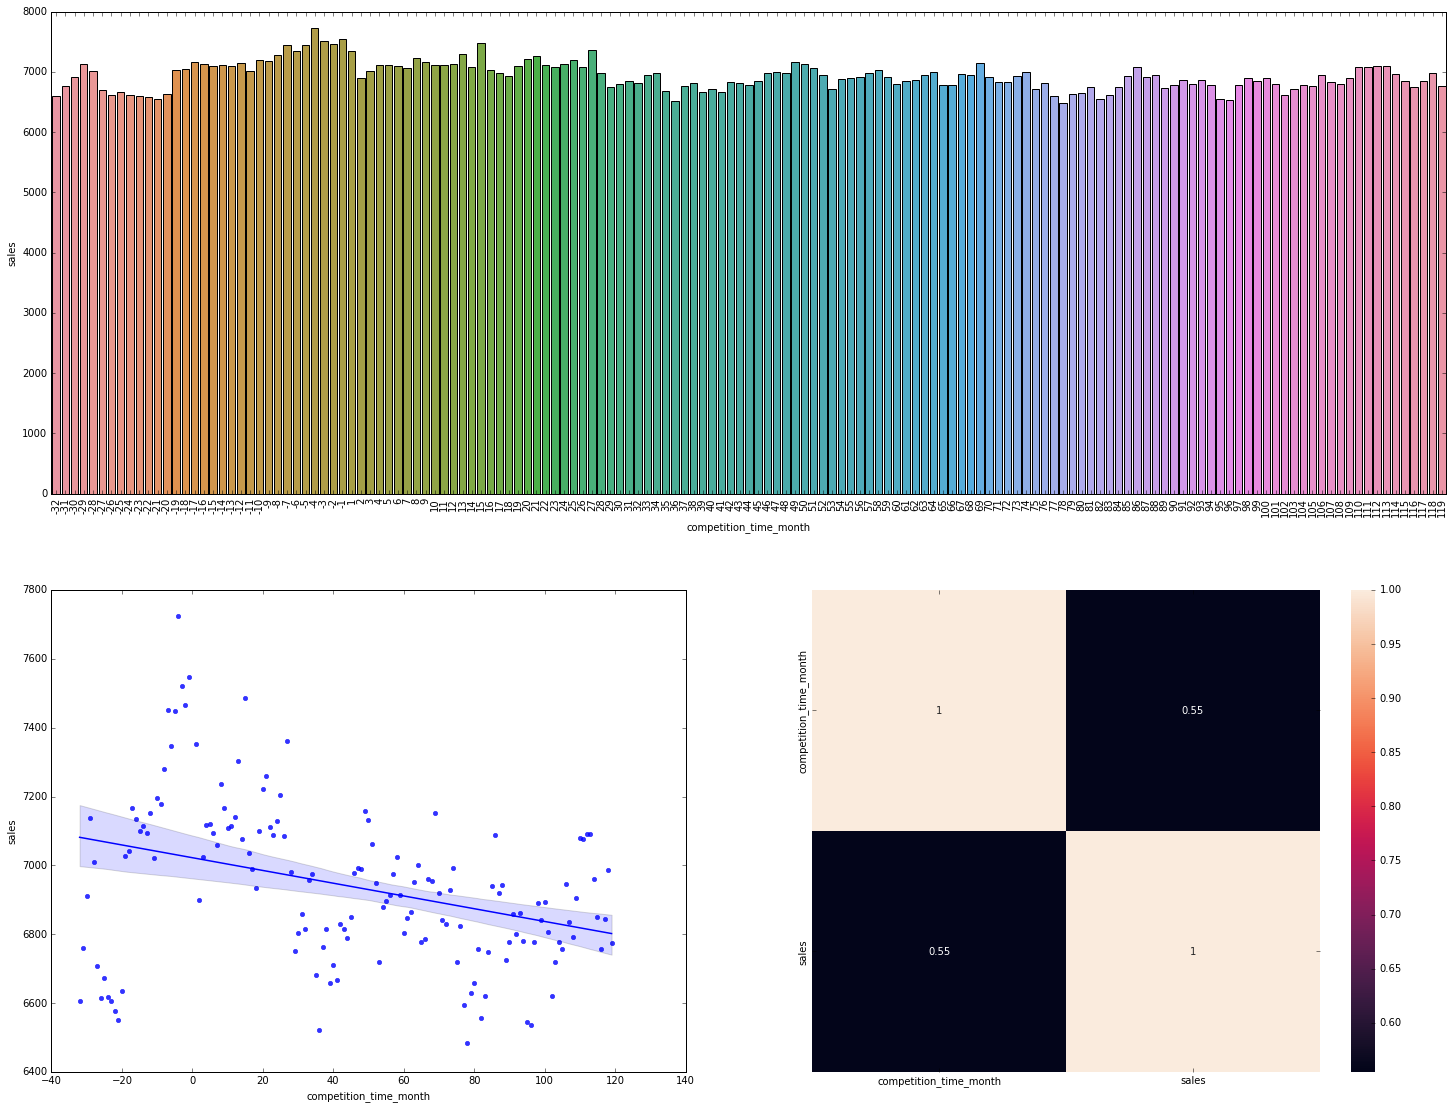

In [34]:
rcParams['figure.figsize'] = 25,19

grid=gridspec.GridSpec(2,2)

plt.subplot(grid[0,:])
# plt.subplot(1,3,1)
aux1=df4[['competition_time_month','sales']].groupby('competition_time_month').mean().reset_index()
aux2=aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] !=0 )]
sns.barplot(x='competition_time_month',y='sales',data=aux2);
# sns.barplot(x='sales',y='competition_time_month',data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[1,0])
# plt.subplot(1,3,2)
sns.regplot(x='competition_time_month',y='sales',data=aux2);

plt.subplot(grid[1,1])
# plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);

### **H4**. Stores with promotions active for longer should sell more
**false** stores with promotions active for longer sell less after a certain period 

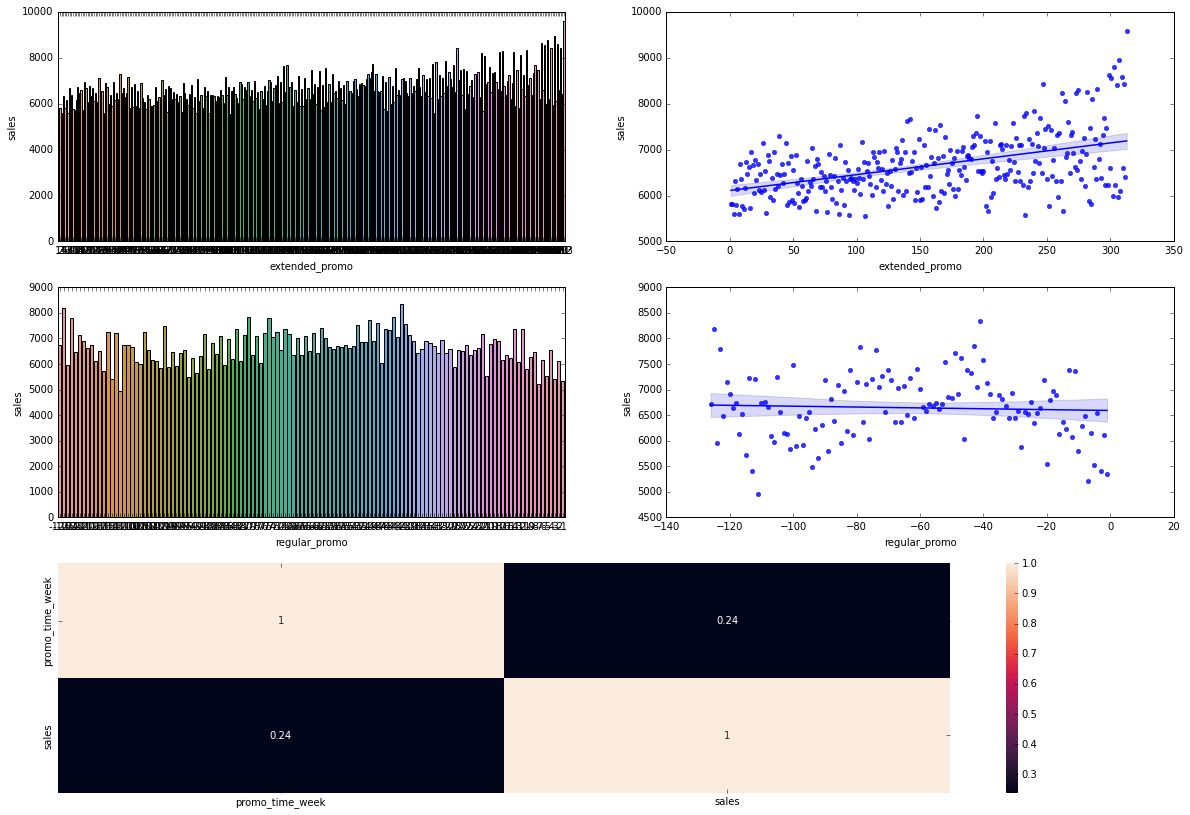

In [35]:
rcParams['figure.figsize'] = 20,14

aux1=df4[['promo_time_week','sales']].groupby('promo_time_week').mean().reset_index()
grid=gridspec.GridSpec(3,2)

plt.subplot(grid[0,0])
aux2=aux1[aux1['promo_time_week'] >0 ]  
aux2=aux2.rename(columns={'promo_time_week':'extended_promo'})
sns.barplot(x='extended_promo',y='sales',data=aux2);

plt.subplot(grid[0,1])
sns.regplot(x='extended_promo',y='sales',data=aux2);

plt.subplot(grid[1,0])
aux3=aux1[aux1['promo_time_week'] <0 ]  
aux3=aux3.rename(columns={'promo_time_week':'regular_promo'})
sns.barplot(x='regular_promo',y='sales',data=aux3);

plt.subplot(grid[1,1])
sns.regplot(x='regular_promo',y='sales',data=aux3);

plt.subplot(grid[2,:])
sns.heatmap(aux1.corr(method='pearson'),annot=True);

### <s>**H5**. Stores with more days on promotion should sell more</s>

### **H6**. Stores with  consecutive promotions should sell more
**true** stores with more consecutive promotions sell more

In [36]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).mean().sort_values(by='sales').reset_index()

,promo,promo2,sales
0,0,1,5529.566684
1,0,0,6328.187633
2,1,1,7836.672987
3,1,0,8618.452062


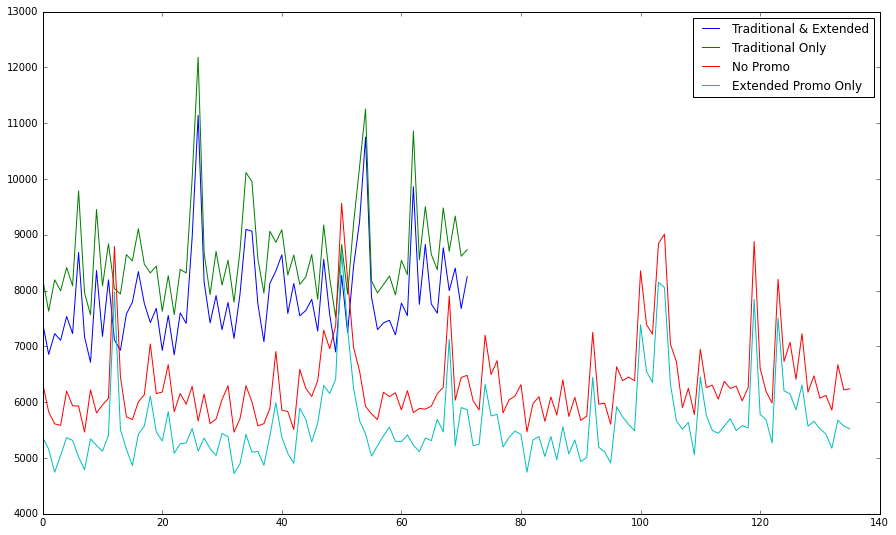

In [37]:
rcParams['figure.figsize'] = 15,9

aux1=df4[(df4['promo']==1) & (df4['promo2'] ==1)][['year_week','sales']].groupby('year_week').mean().reset_index()
ax=aux1.plot()

aux2=df4[(df4['promo']==1) & (df4['promo2'] ==0)][['year_week','sales']].groupby('year_week').mean().reset_index()
aux2.plot(ax=ax)
# ax.legend(labels=['Traditional Only','Traditional & Extended','No Promo','Extended Promo Only']);

aux2=df4[(df4['promo']==0) & (df4['promo2'] ==0)][['year_week','sales']].groupby('year_week').mean().reset_index()
aux2.plot(ax=ax)

aux2=df4[(df4['promo']==0) & (df4['promo2'] ==1)][['year_week','sales']].groupby('year_week').mean().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Traditional & Extended','Traditional Only','No Promo','Extended Promo Only']);

### H7. Stores open over the Christmas holiday sell more comparing to other holidays
**true** Stores open over the Christmas holiday sell more

In [38]:
df4['state_holiday'].value_counts()

regular_day       843428
public_holiday       694
easter_holiday       145
christmas             71
Name: state_holiday, dtype: int64

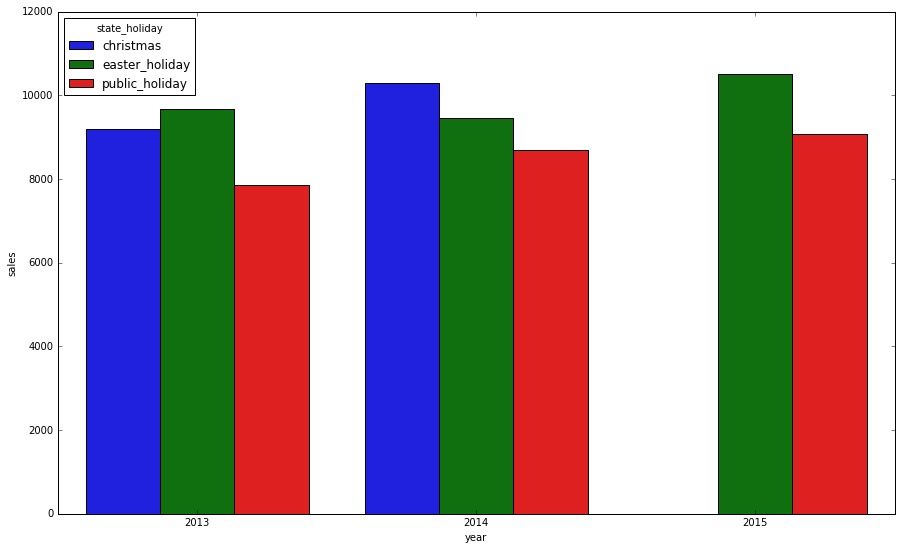

In [39]:
rcParams['figure.figsize'] = 15,9


aux=df4[df4['state_holiday']!= 'regular_day']

# plt.subplot(1,2,1)
# aux1=aux[['state_holiday','sales']].groupby('state_holiday').mean().reset_index()
# sns.barplot(x='state_holiday',y='sales',data=aux1);

# plt.subplot(1,2,2)
aux2=aux[['year','state_holiday','sales']].groupby(['year','state_holiday']).mean().reset_index()
sns.barplot(x='year',y='sales',hue='state_holiday',data=aux2);

### H8. Stores should sell more over the years
**true** stores sell more over the years

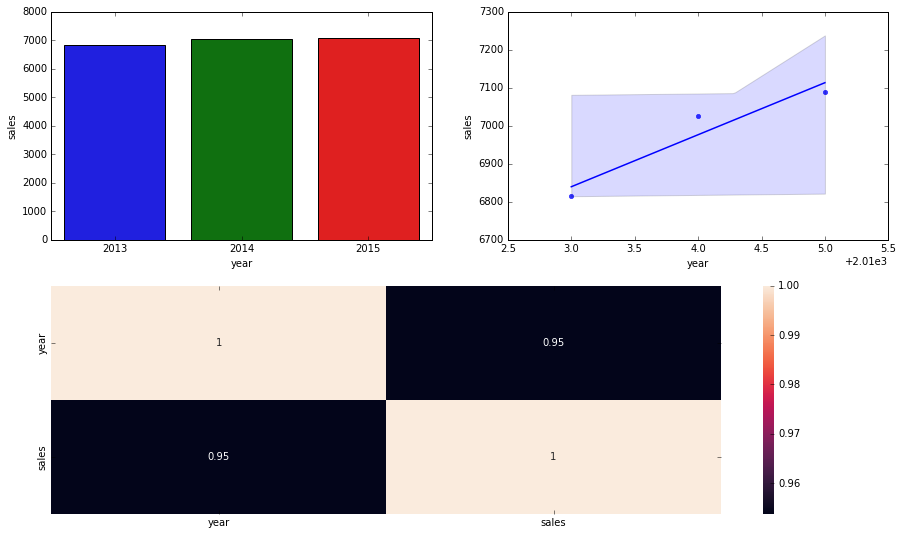

In [40]:
rcParams['figure.figsize'] = 15,9

aux1=df4[['year','sales']].groupby('year').mean().reset_index()

grid=gridspec.GridSpec(2,2)

plt.subplot(grid[0,0])
sns.barplot(x='year',y='sales',data=aux1);

plt.subplot(grid[0,1])
sns.regplot(x='year',y='sales',data=aux1);

plt.subplot(grid[1,:])
sns.heatmap(aux1.corr(method='pearson'),annot=True);

### H9. Stores should sell more in the second half of the year
**true** stores sell more in the second half of the year

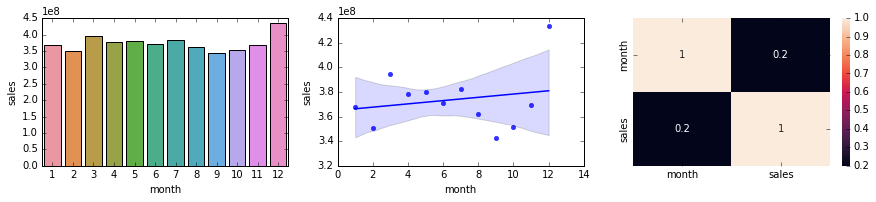

In [41]:
rcParams['figure.figsize'] = 15,9

df=df4[df4['year']<2015]
aux1=df[['month','sales']].groupby('month').sum().reset_index()

plt.subplot(3,3,1)
sns.barplot(x='month',y='sales',data=aux1);

plt.subplot(3,3,2)
sns.regplot(x='month',y='sales',data=aux1);

plt.subplot(3,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);

### H10. Stores should sell more after the 10th of every month
**false** Stores sell less after the 10th of every month

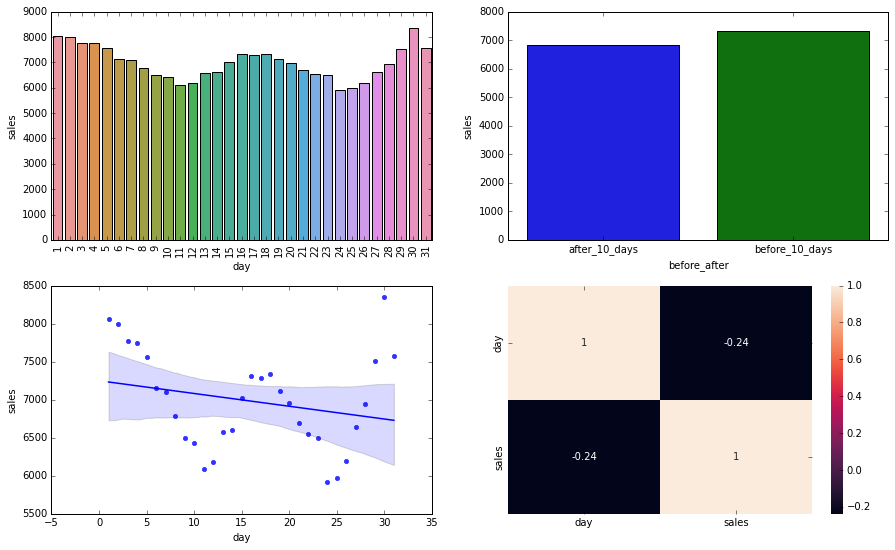

In [42]:
rcParams['figure.figsize'] = 15,9

aux1=df4[['day','sales']].groupby('day').mean().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day',y='sales',data=aux1);
plt.xticks(rotation=90);

plt.subplot(2,2,2)
aux1['before_after']=aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2=aux1[['before_after','sales']].groupby('before_after').mean().sort_values(by='sales').reset_index()
sns.barplot(x='before_after',y='sales',data=aux2);

plt.subplot(2,2,3)
sns.regplot(x='day',y='sales',data=aux1);

plt.subplot(2,2,4)
sns.heatmap(aux1.corr(method='pearson'),annot=True);

### H11. Stores should sell less on weekends
**true** stores sell less on weekends (except on sundays)

In [43]:
df4['day_of_week'].value_counts()

6    144052
2    143955
3    141922
5    138633
1    137557
4    134626
7      3593
Name: day_of_week, dtype: int64

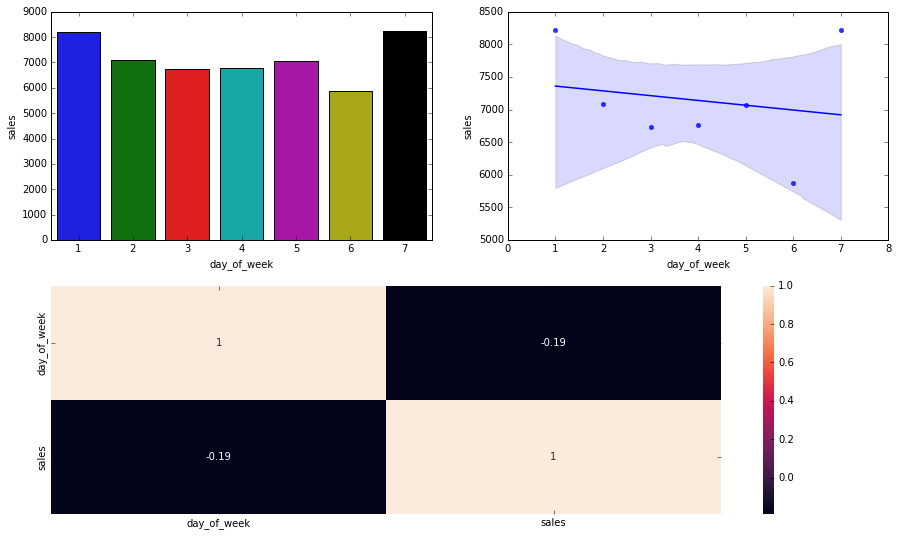

In [44]:
rcParams['figure.figsize'] = 15,9

aux1=df4[['day_of_week','sales']].groupby('day_of_week').mean().reset_index()

grid=gridspec.GridSpec(2,2)

plt.subplot(grid[0,0])
sns.barplot(x='day_of_week',y='sales',data=aux1);

plt.subplot(grid[0,1])
sns.regplot(x='day_of_week',y='sales',data=aux1);

plt.subplot(grid[1,:])
sns.heatmap(aux1.corr(method='pearson'),annot=True);

### H12. Stores should sell less during school holidays
**true** stores sell more during school holidays

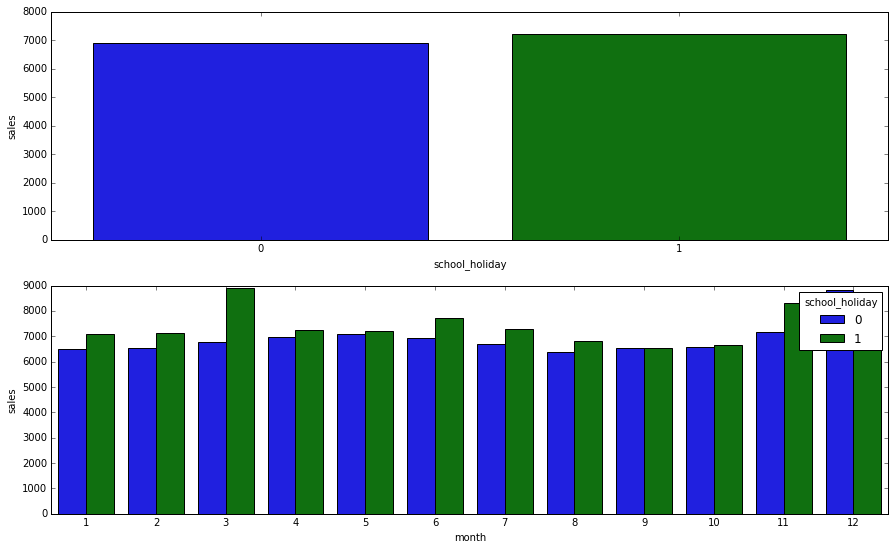

In [45]:
rcParams['figure.figsize'] = 15,9

aux1=df4[['school_holiday','sales']].groupby('school_holiday').mean().reset_index()
plt.subplot(2,1,1)
sns.barplot(x='school_holiday',y='sales',data=aux1);

aux2=df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).mean().reset_index()
plt.subplot(2,1,2)
sns.barplot(x='month',y='sales',hue='school_holiday',data=aux2);

## 4.3 Multivariate analysis


### 4.3.1 Numerical attributes

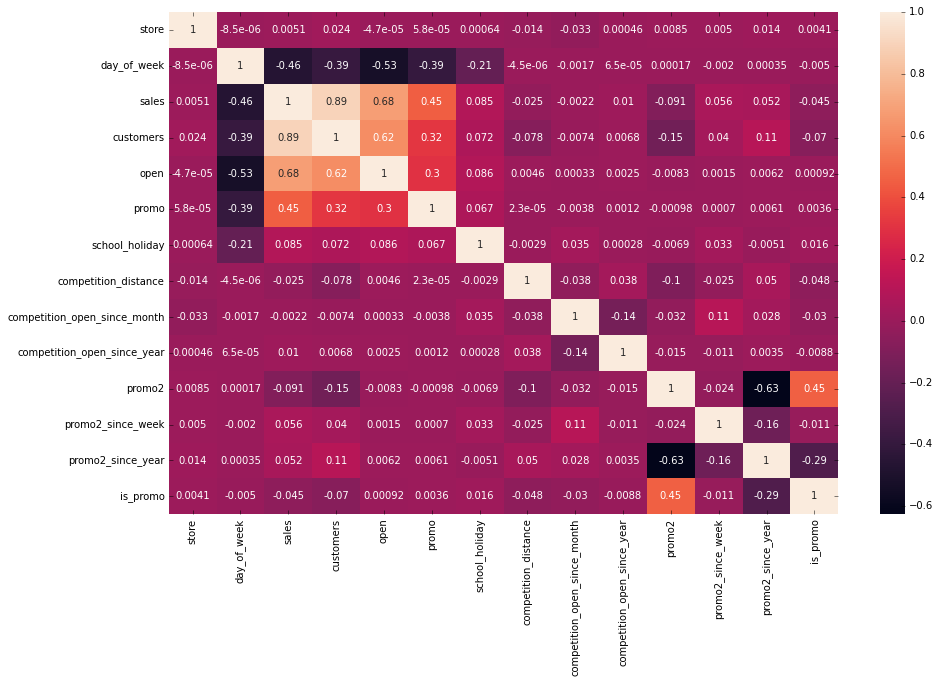

In [46]:
rcParams['figure.figsize'] = 15,9

correlation=num_attributes.corr(method='pearson')
sns.heatmap(correlation,annot=True);

### 4.3.2 Categorical attributes

In [47]:
# categorical data
a=df4.select_dtypes(include='object')

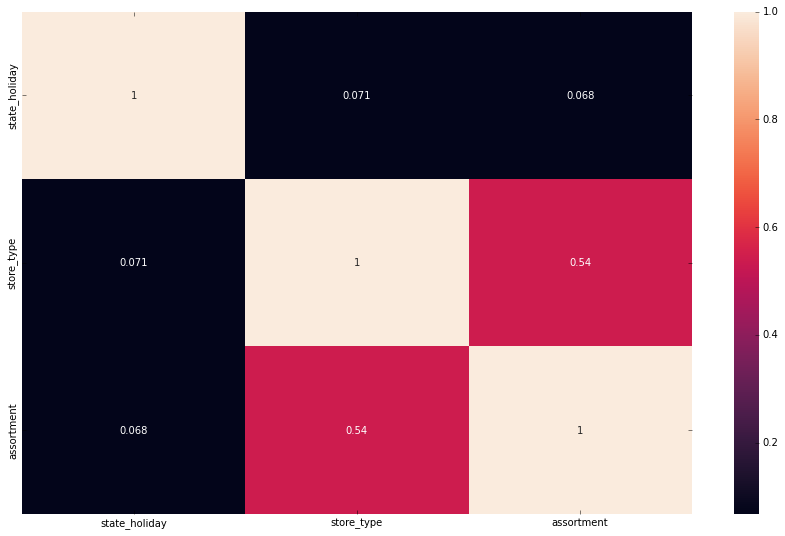

In [48]:
rcParams['figure.figsize'] = 15,9

# calculate cramer V
a1=cramer_v(a['state_holiday'],a['state_holiday'])
a2=cramer_v(a['state_holiday'],a['store_type'])
a3=cramer_v(a['state_holiday'],a['assortment'])

a4=cramer_v(a['store_type'],a['state_holiday'])
a5=cramer_v(a['store_type'],a['store_type'])
a6=cramer_v(a['store_type'],a['assortment'])

a7=cramer_v(a['assortment'],a['state_holiday'])
a8=cramer_v(a['assortment'],a['store_type'])
a9=cramer_v(a['assortment'],a['assortment'])

# final dataset
d=pd.DataFrame({'state_holiday': [a1,a2,a3],
              'store_type': [a4,a5,a6],
              'assortment': [a7,a8,a9]})

d=d.set_index(d.columns);

sns.heatmap(d,annot=True);

#  5 Data preparation

In [49]:
df5=df4.copy()

In [135]:
df5[['store','date']].groupby('store').max().reset_index()['date'][0]-datetime.timedelta(days=6*7)

# the last six weeks start after 2015-06-19 

Timestamp('2015-06-19 00:00:00')

In [136]:
df5[['store','date']].groupby('store').max().reset_index()['date'][0]-datetime.timedelta(days=12*7)

# the last twelve weeks start after 2015-05-08

Timestamp('2015-05-08 00:00:00')

## **5.1 Train, validation and test separation**

In [137]:
# training 
x_train=df5[df5['date']<'2015-05-08']

# validation 
x_val=df5[(df5['date']>='2015-05-08') & (df5['date']<='2015-06-19') ]

# test 
x_test=df5[df5['date']>'2015-06-19']

print('training min date:{}'.format(x_train['date'].min()))
print('training max date:{}'.format(x_train['date'].max()))

print('\nvalidation min date:{}'.format(x_val['date'].min()))
print('validation max date:{}'.format(x_val['date'].max()))

print('\ntest min date:{}'.format(x_test['date'].min()))
print('test max date:{}'.format(x_test['date'].max()))

training min date:2013-01-01 00:00:00
training max date:2015-05-07 00:00:00

validation min date:2015-05-08 00:00:00
validation max date:2015-06-19 00:00:00

test min date:2015-06-20 00:00:00
test max date:2015-07-31 00:00:00


In [138]:
print(len(x_train))
print(len(x_val))
print(len(x_test))

765470
38586
40282


## **<s>5.2 Normalization**</s>

## **5.3 Rescaling**

In [139]:
rs=RobustScaler()   
mms=MinMaxScaler() 

# competition_distance
x_train['competition_distance']=rs.fit_transform(x_train[['competition_distance']].values)
# pickle.dump(rs,open('../src/parameters/competition_distance_scaler.pkl','wb'))                  

x_test['competition_distance']=rs.transform(x_test[['competition_distance']].values)

x_val['competition_distance']=rs.transform(x_val[['competition_distance']].values)


# competition_time_month
x_train['competition_time_month']=rs.fit_transform(x_train[['competition_time_month']].values)
# pickle.dump(rs,open('../src/parameters/competition_time_month_scaler.pkl','wb'))  

x_test['competition_time_month']=rs.transform(x_test[['competition_time_month']].values)

x_val['competition_time_month']=rs.transform(x_val[['competition_time_month']].values)


# promo_time_week
x_train['promo_time_week']=mms.fit_transform(x_train[['promo_time_week']].values)
# pickle.dump(mms,open('../src/parameters/promo_time_week_scaler.pkl','wb'))  

x_test['promo_time_week']=mms.transform(x_test[['promo_time_week']].values)

x_val['promo_time_week']=mms.transform(x_val[['promo_time_week']].values)


# year
x_train['year']=mms.fit_transform(x_train[['year']].values)
# pickle.dump(mms,open('../src/parameters/year_scaler.pkl','wb'))  

x_test['year']=mms.transform(x_test[['year']].values)

x_val['year']=mms.transform(x_val[['year']].values)

## **5.4 Transformation**

### **5.4.1 Encoding**

In [140]:
# state_holiday 
x_train=pd.get_dummies(x_train,prefix=['state_holiday'],columns=['state_holiday'])

x_test=pd.get_dummies(x_test,prefix=['state_holiday'],columns=['state_holiday'])

x_val=pd.get_dummies(x_val,prefix=['state_holiday'],columns=['state_holiday'])

# store type 
le=LabelEncoder()
x_train['store_type']=le.fit_transform(x_train['store_type'])
# pickle.dump( le, open( '../src/parameters/store_type_scaler.pkl', 'wb') )

x_test['store_type']=le.transform(x_test['store_type'])

x_val['store_type']=le.transform(x_val['store_type'])


# assortment 
assortment_dict={'basic':1,'extra':2,'extended':3}
x_train['assortment']=x_train['assortment'].map(assortment_dict)

x_test['assortment']=x_test['assortment'].map(assortment_dict)

x_val['assortment']=x_val['assortment'].map(assortment_dict)

### **5.4.2 Nature Transformation**

In [141]:
# day
x_train['day_sin']=x_train['day'].apply(lambda x: np.sin(x * (2. *np.pi/30)))
x_train['day_cos']=x_train['day'].apply(lambda x: np.cos(x * (2. *np.pi/30)))

x_test['day_sin']=x_test['day'].apply(lambda x: np.sin(x * (2. *np.pi/30)))
x_test['day_cos']=x_test['day'].apply(lambda x: np.cos(x * (2. *np.pi/30)))

x_val['day_sin']=x_val['day'].apply(lambda x: np.sin(x * (2. *np.pi/30)))
x_val['day_cos']=x_val['day'].apply(lambda x: np.cos(x * (2. *np.pi/30)))

# day_of_week
x_train['day_of_week_sin']=x_train['day_of_week'].apply(lambda x: np.sin(x * (2. *np.pi/7)))
x_train['day_of_week_cos']=x_train['day_of_week'].apply(lambda x: np.cos(x * (2. *np.pi/7)))

x_test['day_of_week_sin']=x_test['day_of_week'].apply(lambda x: np.sin(x * (2. *np.pi/7)))
x_test['day_of_week_cos']=x_test['day_of_week'].apply(lambda x: np.cos(x * (2. *np.pi/7)))

x_val['day_of_week_sin']=x_val['day_of_week'].apply(lambda x: np.sin(x * (2. *np.pi/7)))
x_val['day_of_week_cos']=x_val['day_of_week'].apply(lambda x: np.cos(x * (2. *np.pi/7)))


# week_of_year
x_train['week_of_year_sin']=x_train['week_of_year'].apply(lambda x: np.sin(x * (2. *np.pi/52)))
x_train['week_of_year_cos']=x_train['week_of_year'].apply(lambda x: np.cos(x * (2. *np.pi/52))) 

x_test['week_of_year_sin']=x_test['week_of_year'].apply(lambda x: np.sin(x * (2. *np.pi/52)))
x_test['week_of_year_cos']=x_test['week_of_year'].apply(lambda x: np.cos(x * (2. *np.pi/52))) 

x_val['week_of_year_sin']=x_val['week_of_year'].apply(lambda x: np.sin(x * (2. *np.pi/52)))
x_val['week_of_year_cos']=x_val['week_of_year'].apply(lambda x: np.cos(x * (2. *np.pi/52))) 


# month
x_train['month_sin']=x_train['month'].apply(lambda x: np.sin(x * (2. *np.pi/12)))
x_train['month_cos']=x_train['month'].apply(lambda x: np.cos(x * (2. *np.pi/12)))

x_test['month_sin']=x_test['month'].apply(lambda x: np.sin(x * (2. *np.pi/12)))
x_test['month_cos']=x_test['month'].apply(lambda x: np.cos(x * (2. *np.pi/12)))

x_val['month_sin']=x_val['month'].apply(lambda x: np.sin(x * (2. *np.pi/12)))
x_val['month_cos']=x_val['month'].apply(lambda x: np.cos(x * (2. *np.pi/12)))


cols_drop=['day','day_of_week','week_of_year','month','promo_since','competition_since','year_week']

df5=df5.drop(cols_drop,axis=1)
x_train=x_train.drop(cols_drop,axis=1)
x_test=x_test.drop(cols_drop,axis=1)
x_val=x_val.drop(cols_drop,axis=1)

### **5.4.3 Response Variable Transformation**

In [142]:
x_train['sales']=np.log1p(x_train['sales']) 
x_test['sales']=np.log1p(x_test['sales']) 
x_val['sales']=np.log1p(x_val['sales'])

y_train=x_train['sales']
y_val=x_val['sales']
y_test=x_test['sales']

#  6 Feature selection

In [143]:
df6=df5.copy()

## 6.1 Boruta as feature selector

In [34]:
x_train_n=x_train.drop(['date','sales'],axis=1).values  
y_train_n=y_train.values.ravel()  

# define randomForestRegressor
rf=RandomForestRegressor(n_jobs=-1)

# define boruta
boruta=BorutaPy(rf,n_estimators='auto',verbose=0,random_state=42).fit(x_train_n,y_train_n)

KeyboardInterrupt: 

### 6.1.1 Best features from boruta

In [52]:
cols_selected=boruta.support_.tolist() 

# best features
x_train_fs=x_train.drop(['date','sales'],axis=1)
cols_selected_boruta=x_train_fs.iloc[:,cols_selected].columns.to_list() 

cols_not_selected_boruta=list(np.setdiff1d(x_train_fs.columns,cols_selected_boruta))

cols_selected_boruta

In [51]:
cols_not_selected_boruta

## 6.2 Manual feature selection

In [144]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']         

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# **7 Machine learning**

In [145]:
df7=df6.copy()

In [146]:
# cross val preparation
x_training=x_train[cols_selected_boruta_full]  
x_training['date']=pd.to_datetime(x_training['date'], format='%Y-%m-%d')


X_train=x_train[cols_selected_boruta]   
X_val=x_val[cols_selected_boruta]   
X_test=x_test[cols_selected_boruta]   

## **7.1 Average model**

In [19]:
aux1=df7.copy()
yy_val=df7['sales'].copy()

# prediction
aux2=aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})
aux1=pd.merge(aux1,aux2,how='left',on='store')
baseline_yhat=aux1['predictions']   


# performance
baseline_result=ml_error('Average Model',(yy_val),(baseline_yhat))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1456.855044,0.236177,1957.9119


## **7.2 Linear regression model** 

In [153]:
# model
lr=LinearRegression().fit(X_train,y_train)

# prediction
lr_yhat=lr.predict(X_val)

# performance
lr_result=ml_error('Linear Regression',np.expm1(y_val),np.expm1(lr_yhat))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1979.093857,0.283587,2840.2828


### **7.2.1 Linear regression model - Cross validation** 

In [154]:
lr_result_cv=cross_validation(x_training,5,'Linear Regression',lr,verbose=False)
lr_result_cv

,Model name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2059.68 +/-306.3,0.31 +/-0.01,2895.95 +/-494.88


## **7.3 Linear regression regularized model - Lasso**

In [22]:
# model
lrr=Lasso().fit(X_train,y_train)
 

# prediction
lrr_yhat=lrr.predict(X_val)

# performance
lrr_result=ml_error('Linear Regression - Lasso',np.expm1(y_val),np.expm1(lrr_yhat))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,2222.852114,0.317109,3183.112874


### **7.3.1 Linear regression regularized model - Lasso - Cross validation** 

In [23]:
lrr_result_cv=cross_validation(x_training,5,'Lasso',lr,verbose=False)
lrr_result_cv

,Model name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2059.68 +/-306.3,0.31 +/-0.01,2895.95 +/-494.88


## **7.4 Random Forest Regressor**

In [24]:
# model
rf=RandomForestRegressor(n_jobs=-1,max_depth=1,random_state=95).fit(X_train,y_train)

# prediction
rf_yhat=rf.predict(X_val)

# performance
rf_result=ml_error('Random Forest Regressor',np.expm1(y_val),np.expm1 (rf_yhat))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,2076.803442,0.290728,2998.016599


### **7.4.1 Random forest regressor - Cross validation** 

In [25]:
rf_result_cv=cross_validation(x_training,5,'Random forest regressor',rf,verbose=False)
rf_result_cv

,Model name,MAE CV,MAPE CV,RMSE CV
0,Random forest regressor,2147.58 +/-379.67,0.31 +/-0.01,3069.46 +/-574.2


## **7.5 XGBoost Regressor**

In [26]:
xgb_model=xgb.XGBRegressor(n_jobs=-1,random_state=95).fit(X_train,y_train)

# prediction
xgb_yhat=xgb_model.predict(X_val)

# performance
xgb_result=ml_error('XGBoost Regressor',np.expm1(y_val),np.expm1(xgb_yhat))
xgb_result

[09:20:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1815.224021,0.250571,2612.662833


### **7.5.1 XGBoost regressor - Cross validation** 

In [27]:
xgb_result_cv=cross_validation(x_training,5,'XGBoost regressor',xgb_model,verbose=False)
xgb_result_cv

[09:21:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:21:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:22:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:22:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:23:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,Model name,MAE CV,MAPE CV,RMSE CV
0,XGBoost regressor,1809.28 +/-216.92,0.26 +/-0.01,2579.95 +/-307.24


## **7.6 CatBoost Regressor**

In [28]:
cat=CatBoostRegressor(logging_level='Silent').fit(X_train,y_train)

# prediction
cat_yhat=cat.predict(X_val)

# performance
cat_result=ml_error('CatBoost Regressor',np.expm1(y_val),np.expm1(cat_yhat))
cat_result

,Model Name,MAE,MAPE,RMSE
0,CatBoost Regressor,913.422969,0.128842,1286.245933


### **7.6.1 CatBoost Regressor - Cross Validation**

In [29]:
cat_result_cv=cross_validation(x_training,5,'CatBoost Regressor',cat,verbose=False)
cat_result_cv

,Model name,MAE CV,MAPE CV,RMSE CV
0,CatBoost Regressor,969.44 +/-193.02,0.14 +/-0.02,1403.51 +/-296.99


## **7.7 Compare model's performance regressor**

### **7.7.1  Single performance**

In [30]:
modelling_result=pd.concat([baseline_result,lr_result,lrr_result,rf_result,xgb_result,cat_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,CatBoost Regressor,913.422969,0.128842,1286.245933
0,Average Model,1456.855044,0.236177,1957.911900
0,XGBoost Regressor,1815.224021,0.250571,2612.662833
0,Linear Regression,1979.093857,0.283587,2840.282800
0,Random Forest Regressor,2076.803442,0.290728,2998.016599
0,Linear Regression - Lasso,2222.852114,0.317109,3183.112874


### **7.7.2 Real performance - Cross validation**

In [31]:
modelling_result_cv=pd.concat([lr_result_cv,lrr_result_cv,rf_result_cv,xgb_result_cv,cat_result_cv])
modelling_result_cv.sort_values('RMSE CV')

,Model name,MAE CV,MAPE CV,RMSE CV
0,CatBoost Regressor,969.44 +/-193.02,0.14 +/-0.02,1403.51 +/-296.99
0,XGBoost regressor,1809.28 +/-216.92,0.26 +/-0.01,2579.95 +/-307.24
0,Linear Regression,1988.29 +/-229.5,0.31 +/-0.01,2801.41 +/-367.31
0,Lasso,2059.68 +/-306.3,0.31 +/-0.01,2895.95 +/-494.88
0,Random forest regressor,2147.58 +/-379.67,0.31 +/-0.01,3069.46 +/-574.2


# **8 Final Model**

## **8.1 Hyperparameter fine tuning - Random Search**

In [54]:
df8=df7.copy()

In [56]:
parameters={'depth':[2,4,6,8,10],
                  'learning_rate':[0.01,0.03,0.05,0.7,1],
                 }
max_eval=20


final_result=pd.DataFrame()               

for i in range(max_eval):
    
#     choose values for parameters randomly
    hp={k:random.sample(v,1)[0] for k,v in parameters.items()}
    print(hp)

    # model
    cat_model=CatBoostRegressor(depth=hp['depth'],
                                   learning_rate=hp['learning_rate'],
                                   logging_level='Silent')

    # performance
    result=cross_validation(x_training,2,'CatBoost Regressor',cat_model,verbose=False)
    final_result=pd.concat([final_result,result])
    
final_result    

{'depth': 4, 'learning_rate': 0.7}
{'depth': 2, 'learning_rate': 1}
{'depth': 2, 'learning_rate': 0.05}
{'depth': 2, 'learning_rate': 0.01}
{'depth': 8, 'learning_rate': 0.01}
{'depth': 2, 'learning_rate': 0.01}
{'depth': 4, 'learning_rate': 0.01}
{'depth': 6, 'learning_rate': 0.7}
{'depth': 6, 'learning_rate': 1}
{'depth': 4, 'learning_rate': 0.01}
{'depth': 2, 'learning_rate': 0.03}
{'depth': 10, 'learning_rate': 1}
{'depth': 8, 'learning_rate': 0.03}
{'depth': 8, 'learning_rate': 0.03}
{'depth': 6, 'learning_rate': 0.01}
{'depth': 10, 'learning_rate': 0.05}
{'depth': 8, 'learning_rate': 0.7}
{'depth': 2, 'learning_rate': 0.05}
{'depth': 4, 'learning_rate': 0.03}
{'depth': 4, 'learning_rate': 0.05}


,Model name,MAE CV,MAPE CV,RMSE CV
0,CatBoost Regressor,895.96 +/-129.91,0.13 +/-0.01,1281.47 +/-177.94
0,CatBoost Regressor,1226.81 +/-148.44,0.18 +/-0.01,1730.59 +/-181.28
0,CatBoost Regressor,1731.83 +/-139.74,0.25 +/-0.0,2516.44 +/-217.63
0,CatBoost Regressor,1882.95 +/-158.04,0.27 +/-0.0,2725.0 +/-255.06
0,CatBoost Regressor,1466.34 +/-139.4,0.21 +/-0.0,2138.6 +/-218.62
0,CatBoost Regressor,1882.95 +/-158.04,0.27 +/-0.0,2725.0 +/-255.06
0,CatBoost Regressor,1767.32 +/-151.27,0.25 +/-0.0,2563.49 +/-241.66
0,CatBoost Regressor,843.97 +/-183.65,0.12 +/-0.02,1230.32 +/-261.12
0,CatBoost Regressor,915.93 +/-183.23,0.13 +/-0.01,1321.31 +/-293.31
0,CatBoost Regressor,1767.32 +/-151.27,0.25 +/-0.0,2563.49 +/-241.66


## **8.2 Generalization ability**

In [105]:
full_x=pd.merge(X_train, X_val,how='outer')

full_y=pd.concat ([y_train, y_val], axis=0) 
            
cat_tuned=CatBoostRegressor(depth=6,
                                   learning_rate=0.7,
                                   logging_level='Silent').fit(full_x,full_y)

# # prediction              
yhat_cat_tuned=cat_tuned.predict(X_test)

# # performance
cat_result_tuned=ml_error('CatBoost Regressor',np.expm1(y_test),np.expm1(yhat_cat_tuned)) 
cat_result_tuned

,Model Name,MAE,MAPE,RMSE
0,CatBoost Regressor,714.624062,0.101595,1045.375276


# **9  Error translation and interpretation**

In [106]:
df9=x_test[cols_selected_boruta_full]

# rescale
df9['sales']=np.expm1(df9['sales'])
df9['predictions']=np.expm1(yhat_cat_tuned)

## **9.1 Business performance**

In [128]:
# sum of predictions
df91=df9[['store','predictions']].groupby('store').sum().reset_index()              
# MAE and MAPE
df9_aux1=df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_error (x['sales'],x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2=df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error (x['sales'],x['predictions'])).reset_index().rename(columns={0:'MAPE'})

# merge
df9_aux3=pd.merge(df9_aux1,df9_aux2,how='inner',on='store')
df92=pd.merge(df91,df9_aux3,how='inner',on='store')

# scenarios
df92['worst_scenario']=df92['predictions'] - df92['MAE']
df92['best_scenario']=df92['predictions'] + df92['MAE']

# order columns
df92=df92[['store','predictions','worst_scenario','best_scenario','MAE','MAPE']]

df92['predictions']=df92['predictions'].map('€{:,.2f}'.format)
df92['worst_scenario']=df92['worst_scenario'].map('€{:,.2f}'.format)
df92['best_scenario']=df92['best_scenario'].map('€{:,.2f}'.format)

In [130]:
df92.sort_values('MAPE',ascending=True).head()

# Top 5 best predictions

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
989,990,"€226,659.18","€226,329.09","€226,989.26",330.084451,0.051670
732,733,"€607,486.45","€606,727.16","€608,245.75",759.290514,0.051901
1088,1089,"€363,197.55","€362,631.85","€363,763.24",565.693913,0.053055
380,381,"€320,858.00","€320,348.11","€321,367.89",509.886060,0.054255
1074,1075,"€418,342.92","€417,696.70","€418,989.13",646.213531,0.056438


In [129]:
df92.sort_values('MAPE',ascending=False).head()

# Top 5 worst predictions

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,"€97,495.34","€93,984.37","€101,006.32",3510.972598,0.592659
908,909,"€219,851.75","€211,739.67","€227,963.83",8112.082760,0.552191
594,595,"€289,771.93","€283,556.51","€295,987.35",6215.418620,0.431879
875,876,"€196,835.31","€192,768.31","€200,902.31",4066.999498,0.309925
273,274,"€186,474.39","€184,993.12","€187,955.66",1481.270013,0.256193


In [124]:
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_cat_tuned ) )
mpe

0.018021414568379374

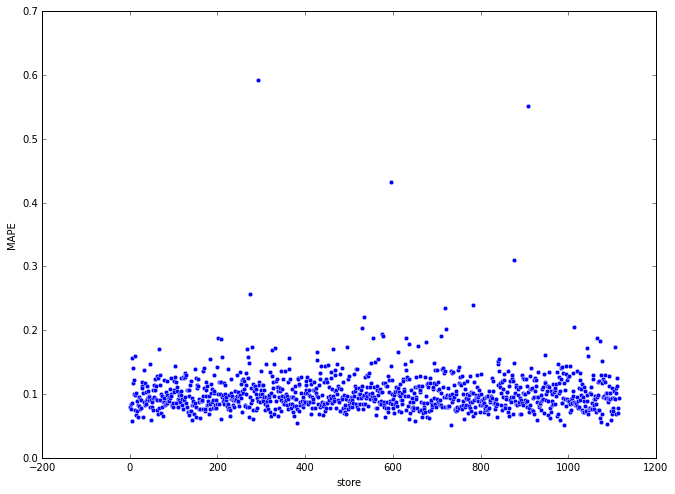

In [112]:
rcParams['figure.figsize'] = 11,8

sns.scatterplot(x='store',y='MAPE',data=df92);

## **9.2 Total Performance**

In [125]:
df93=df92[['predictions','worst_scenario','best_scenario']].apply(lambda x: np.sum (x),axis=0).reset_index().rename(columns={'index':'Scenario',0:'Values'}) 
df93['Values']=df93['Values'].map('€{:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"€271,246,791.06"
1,worst_scenario,"€270,446,309.84"
2,best_scenario,"€272,047,272.29"


## **9.3 Machine learning performance**

In [116]:
df9['error']=df9['sales']-df9['predictions']
df9['error_rate']=df9['predictions']/df9['sales']

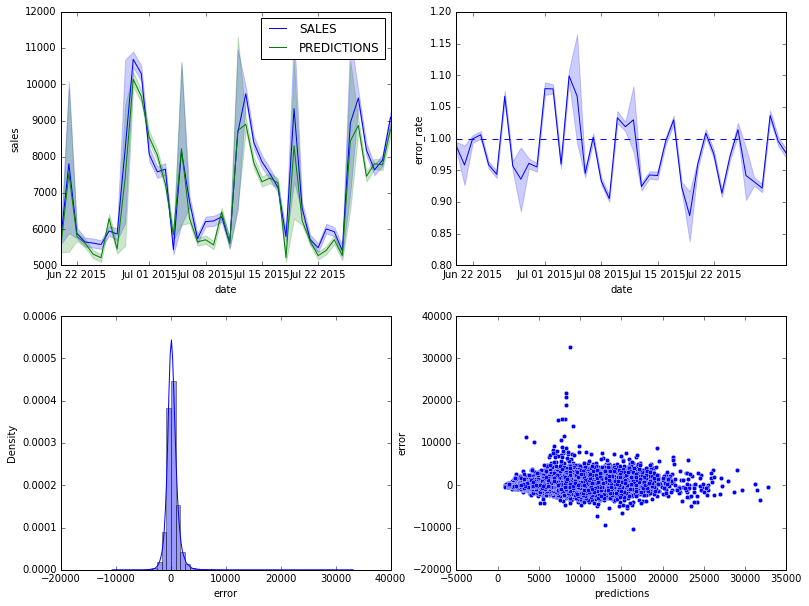

In [117]:
rcParams['figure.figsize'] = 13,10

plt.subplot(2,2,1)
sns.lineplot(x='date',y='sales',data=df9,label='SALES')
sns.lineplot(x='date',y='predictions',data=df9,label='PREDICTIONS')


plt.subplot(2,2,2)
sns.lineplot(x='date',y='error_rate',data=df9)
plt.axhline(1,linestyle='--')


plt.subplot(2,2,3)
sns.distplot(df9['error'])


plt.subplot(2,2,4)
sns.scatterplot(x=df9['predictions'],y=df9['error'],data=df9);

# **10 Deploy model to production**

In [137]:
# save trained model
# pickle.dump(cat_tuned,open('model/model_rossmann.pkl','wb')) 

## **10.1 Rossmann class**

In [113]:
import pickle
import inflection
import pandas as pd
import numpy  as np
import math
import datetime

class Rossmann(object):
    
    def __init__(self):          
#         self.home_path=''
        self.competition_distance_scaler=pickle.load  (open('parameter/competition_distance_scaler.pkl','rb'))     # rb por ser leitura          
        self.competition_time_month_scaler=pickle.load(open('parameter/competition_time_month_scaler.pkl','rb'))  #arrumar pra absoluto depois
        self.promo_time_week_scaler=pickle.load       (open('parameter/promo_time_week_scaler.pkl','rb'))  
        self.year_scaler=pickle.load                  (open('parameter/year_scaler.pkl','rb'))
        self.store_type_scaler=pickle.load            (open('parameter/store_type_scaler.pkl','rb'))
        
        
    def data_cleaning(self,df1): 
                                    
    ## 1.1 Rename columns

        cols_old=['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 
               'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
               'CompetitionDistance', 'CompetitionOpenSinceMonth',
               'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
               'Promo2SinceYear', 'PromoInterval']

        snakecase=lambda x: inflection.underscore(x)
        cols_new=list(map(snakecase,cols_old))

        # rename
        df1.columns=cols_new


        ## 1.3 Data types

        df1['date']=pd.to_datetime(df1['date'])


        ## 1.5 Fillout NA

        # competition_distance            
        df1['competition_distance']=df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)


        # competition_open_since_month    
        df1['competition_open_since_month']=df1.apply( lambda x: x['date'].month if math.isnan (x['competition_open_since_month'] )
                                                                                       else x ['competition_open_since_month'],axis=1 )

        # competition_open_since_year   
        df1['competition_open_since_year']=df1.apply( lambda x: x['date'].year if math.isnan (x['competition_open_since_year'] )
                                                                                       else x ['competition_open_since_year'],axis=1 )

        # promo2_since_week               
        df1['promo2_since_week']=df1.apply( lambda x: x['date'].week if math.isnan (x['promo2_since_week'] )
                                                                                       else x ['promo2_since_week'],axis=1 )

        # promo2_since_year             
        df1['promo2_since_year']=df1.apply( lambda x: x['date'].year if math.isnan (x['promo2_since_year'] )
                                                                                       else x ['promo2_since_year'],axis=1 )

        #promo_interval
        month_map={1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sept',10:'Oct',11:'Nov',12:'Dec'}

        df1['promo_interval'].fillna(0,inplace=True)

        df1['month_map']  = df1['date'].dt.month.map( month_map )

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )


        ## 1.6 Change Types

        # competiton
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

        return df1

    
    def feature_engineering(self,df2):    

        # year
        df2['year']=df2['date'].dt.year


        # month
        df2['month']=df2['date'].dt.month


        # day
        df2['day']=df2['date'].dt.day


        # week of year
        df2['week_of_year']=df2['date'].dt.weekofyear


        # year week
        df2['year_week']=df2['date'].dt.strftime('%Y-%W')


        # competition since
        df2['competition_since']=df2.apply (lambda x: datetime.datetime(year=x['competition_open_since_year'],month=x['competition_open_since_month'],day=1),axis=1)
        df2['competition_time_month']=((df2['date']-df2['competition_since'])/30).apply(lambda x: x.days).astype(int)


        # promo since
        df2['promo_since']=df2['promo2_since_year'].astype(str)+'-'+df2['promo2_since_week'].astype(str)
        df2['promo_since']=df2['promo_since'].apply(lambda x: datetime.datetime.strptime (x+'-1', '%Y-%W-%w')) - datetime.timedelta(days=7)
        df2['promo_time_week']=((df2['date']-df2['promo_since'])/7).apply(lambda x: x.days).astype(int)


        # assortment
        df2['assortment']=df2['assortment'].apply(lambda x: 'basic'if x =='a' else 'extra' if x == 'b' else 'extended')


        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )


        # Passo 3 Filtragem de variáveis

        ## 3.1 Filtragem das linhas

        df2=df2[(df2['open']==1)] 
        df2=df2[(df2['sales']>0)]

        ## 3.2 Filtragem de colunas

        cols_drop=['open','promo_interval','month_map']
        df2=df2.drop(cols_drop,axis=1)

        return df2

    
    def data_preparation (self,df5):
            
    ## 5.2 Rescaling

        # competition_distance
        df5['competition_distance']=self.competition_distance_scaler.transform(df5[['competition_distance']].values) # ñ pode mais ler o rs da biblioteca, e sim do arquivo salvo


        # competition_time_month
        df5['competition_time_month']=self.competition_time_month_scaler.transform(df5[['competition_time_month']].values)


        # promo_time_week
        df5['promo_time_week']=self.promo_time_week_scaler.transform(df5[['promo_time_week']].values)


        # year
        df5['year']=self.year_scaler.transform( df5[['year']].values )


        ### 5.3.1 Encoding

        # state_holiday - One Hot Encoding
        df5=pd.get_dummies(df5,prefix=['state_holiday'],columns=['state_holiday'])


        # store type - Label Encoding
        df5['store_type']=self.store_type_scaler.transform(df5['store_type'])

        # assortment - Ordinal Encoding
        assortment_dict={'basic':1,'extra':2,'extended':3}
        df5['assortment']=df5['assortment'].map(assortment_dict)


        ### 5.3.3 Nature Transformation

        # day_of_week
        df5['day_of_week_sin']=df5['day_of_week'].apply(lambda x: np.sin(x * (2. *np.pi/7)))
        df5['day_of_week_cos']=df5['day_of_week'].apply(lambda x: np.cos(x * (2. *np.pi/7)))


        # month
        df5['month_sin']=df5['month'].apply(lambda x: np.sin(x * (2. *np.pi/12)))
        df5['month_cos']=df5['month'].apply(lambda x: np.cos(x * (2. *np.pi/12)))


        # day
        df5['day_sin']=df5['day'].apply(lambda x: np.sin(x * (2. *np.pi/30)))
        df5['day_cos']=df5['day'].apply(lambda x: np.cos(x * (2. *np.pi/30)))


        # week_of_year
        df5['week_of_year_sin']=df5['week_of_year'].apply(lambda x: np.sin(x * (2. *np.pi/52)))
        df5['week_of_year_cos']=df5['week_of_year'].apply(lambda x: np.cos(x * (2. *np.pi/52))) 


        cols_selected = [
        'store',
        'promo',
        'store_type',
        'assortment',
        'competition_distance',
        'competition_open_since_month',
        'competition_open_since_year',
        'promo2',
        'promo2_since_week',
        'promo2_since_year',
        'competition_time_month',
        'promo_time_week',
        'day_of_week_sin',
        'day_of_week_cos',
        'month_sin',
        'month_cos',
        'day_sin',
        'day_cos',
        'week_of_year_sin',
        'week_of_year_cos']

        return df5[cols_selected]        

    def get_prediction(self,model,original_data,test_data):
#             prediction
        pred=model.predict(test_data)

#             join pred into the original data     
        original_data['prediction']=np.expm1(pred)    

        return original_data.to_json (orient='records',date_format='iso')  

## **10.2 Api handler**

In [26]:
import pickle
import pandas as pd
from flask             import Flask, request, Response
from rossmann.Rossmann import Rossmann 

# loading model
model=pickle.load(open('model/model_rossmann.pkl','rb'))

# initialize API
app=Flask(__name__)                              

@app.route('/rossmann/predict',methods=['POST'])    
def rossmann_predict():                                 
    test_json=request.get_json()                        

    if test_json:               
        # unique example
        if isinstance(test_json,dict):
            teste_raw=pd.DataFrame(test_json,index[0])             
        
        # multiple examples
        else:
            test_raw=pd.DataFrame(test_json,columns=test_json[0].keys())
        
        # instanciate rossmann class
        pipeline=Rossmann()                           
        
        # data cleaning
        df1=pipeline.data_cleaning(test_raw)            
        
        # feature engineering
        df2=pipeline.feature_engineering(df1)
        
        # data preparation
        df3=pipeline.data_preparation(df2)
        
        # prediction
        df_response=pipeline.get_prediction(model,test_raw,df3)
        
        return df_response      
        
    else:                
        return Response ('{}',status=200,mimetype='application/json')  
                                                                                

            
if __name__ == '__main__':             
    app.run('0.0.0.0')                  

## **10.3 API tester**

In [5]:
import requests
import json

In [6]:
# loading test dataset
df10=pd.read_csv('../data/test.csv') 

In [7]:
# merge test dataset + store
df_test=pd.merge(df10,df_store_raw,how='left',on='Store')

# choose store for prediction              
# df_test=df_test[df_test['Store']==22]
df_test=df_test[df_test['Store'].isin([21,25,35,40,91])]

# remove closed days
df_test=df_test[df_test['Open'] !=0]
df_test=df_test[~df_test['Open'].isnull()] 
df_test=df_test.drop('Id',axis=1)

In [8]:
# convert dataframe to json
data=json.dumps(df_test.to_dict(orient='records'))

In [9]:
# API Call
# url='http://0.0.0.0:5000/rossmann/predict' 
url='https://rossmann-webapp-86pb.onrender.com/rossmann/predict'
    
# indica pra api o tipo de dado a ser recebido
header={'Content-type':'application/json'}
data=data

r=requests.post(url,data=data,headers=header)
print('Status Code {}'.format(r.status_code))

Status Code 200


In [10]:
d1=pd.DataFrame(r.json(),columns=r.json()[0].keys()) 
d1.head()

,store,day_of_week,date,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,prediction
0,21,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,c,extended,550.0,...,2015,9,17,38,2015-37,1999-10-01T00:00:00.000Z,194,2009-11-02T00:00:00.000Z,306,5680.279218
1,25,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,c,basic,430.0,...,2015,9,17,38,2015-37,2003-04-01T00:00:00.000Z,151,2015-09-14T00:00:00.000Z,0,10345.932089
2,35,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,d,extended,7660.0,...,2015,9,17,38,2015-37,2000-10-01T00:00:00.000Z,182,2011-12-26T00:00:00.000Z,194,10886.975586
3,40,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,a,basic,180.0,...,2015,9,17,38,2015-37,2015-09-01T00:00:00.000Z,0,2009-11-02T00:00:00.000Z,306,4736.104527
4,91,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,c,basic,2410.0,...,2015,9,17,38,2015-37,2015-09-01T00:00:00.000Z,0,2011-08-22T00:00:00.000Z,212,5414.036696


In [11]:
d2=d1[['store','prediction']].groupby('store').sum().reset_index()

for i in range (len(d2)):
    print('Store number {} will sell R${:,.2f} in the next 6 weeks'.format(
            d2.loc[i,'store'],
            d2.loc[i,'prediction']))

Store number 21 will sell R$218,412.45 in the next 6 weeks
Store number 25 will sell R$419,005.46 in the next 6 weeks
Store number 35 will sell R$419,620.75 in the next 6 weeks
Store number 40 will sell R$194,081.21 in the next 6 weeks
Store number 91 will sell R$214,771.38 in the next 6 weeks


In [69]:
# data